In [62]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy.random

plt.rcParams["figure.figsize"] = (25, 25)

In [63]:
school_filenames = ["teacher_schools.json", "student_schools.json"]
school_positions = []

for index, name in enumerate(school_filenames):
    file = open(name)
    data = json.load(file)
    points = []
    for coord, value in data.items():
        x, y = eval(coord)
        points.append((x, y, value))
    school_positions.append(points)

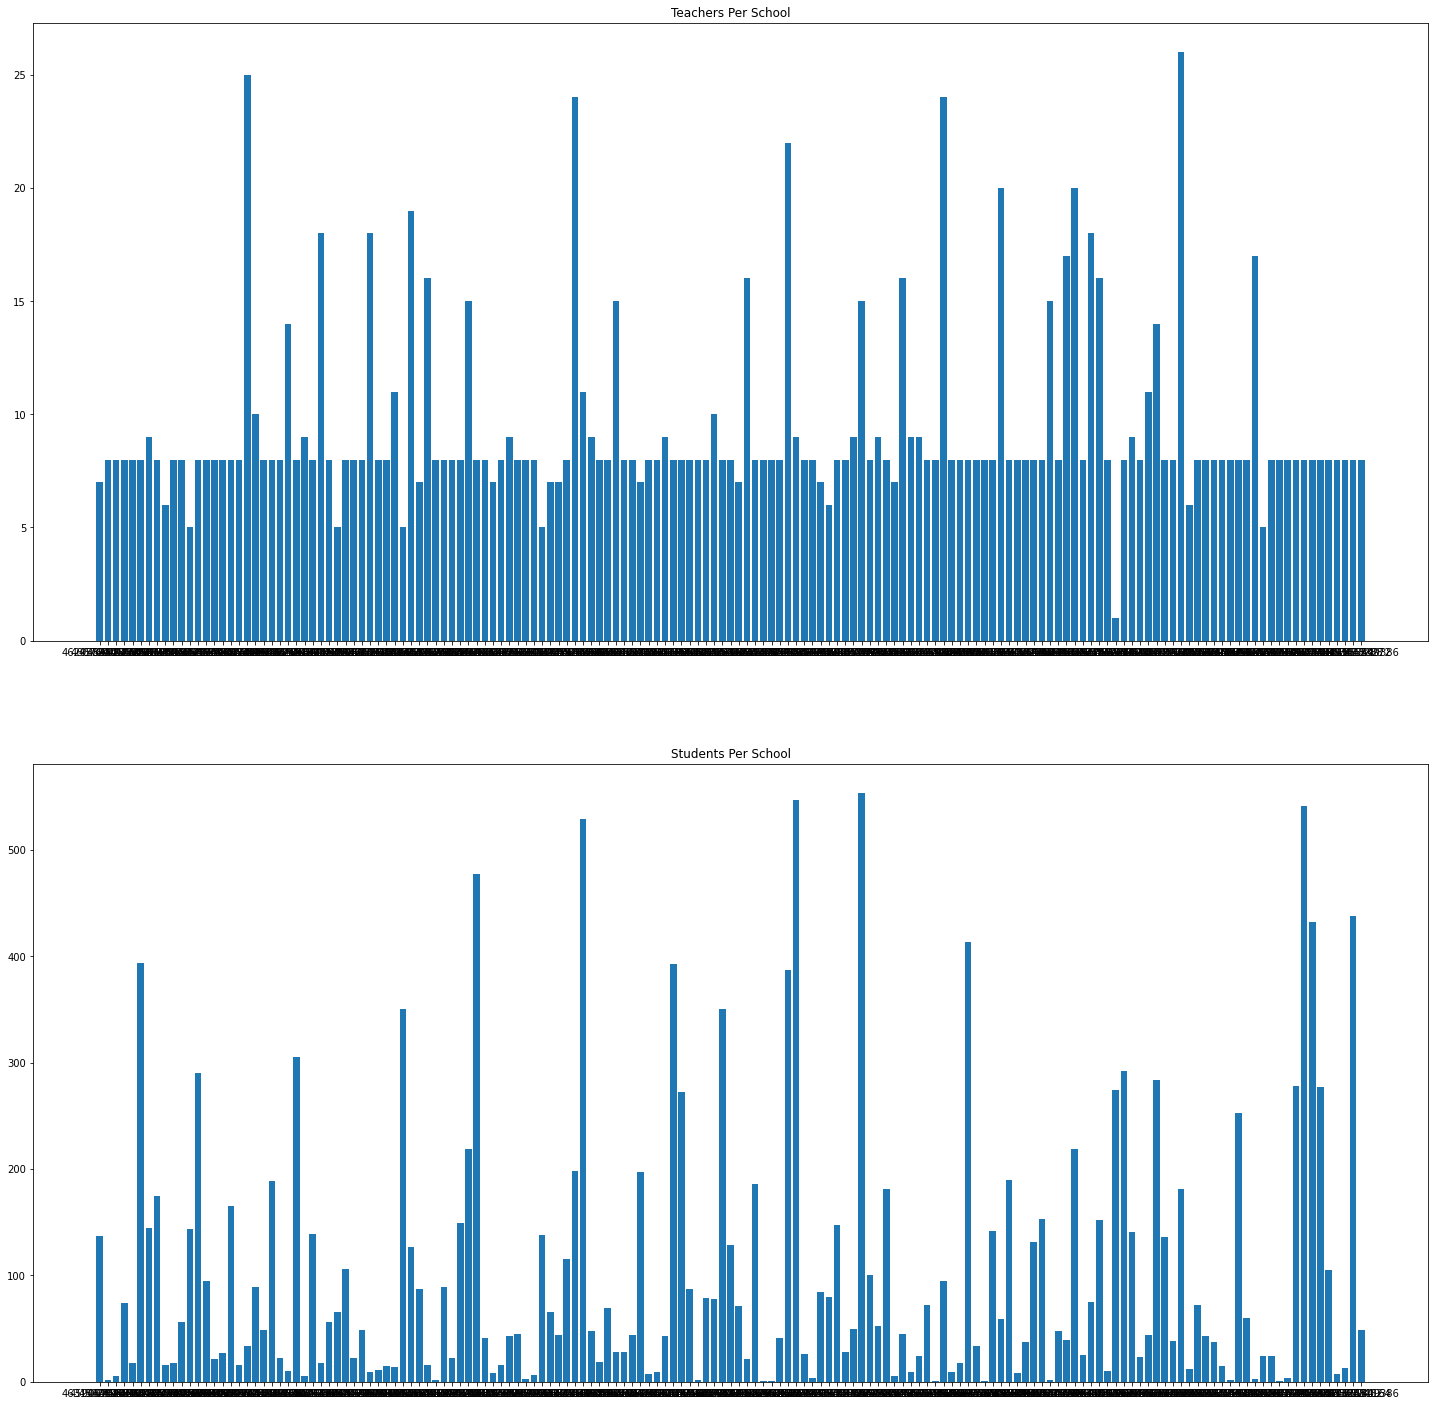

In [64]:
fig, axes = plt.subplots(2)
for index, name in enumerate(["Teachers Per School", "Students Per School"]):
    names = list(map(lambda x: str(str(x[0]) + str(x[1])), school_positions[index]))
    values = list(map(lambda x: (x[2]), school_positions[index]))
    axes[index].bar(names, values)
    axes[index].set_title(name)

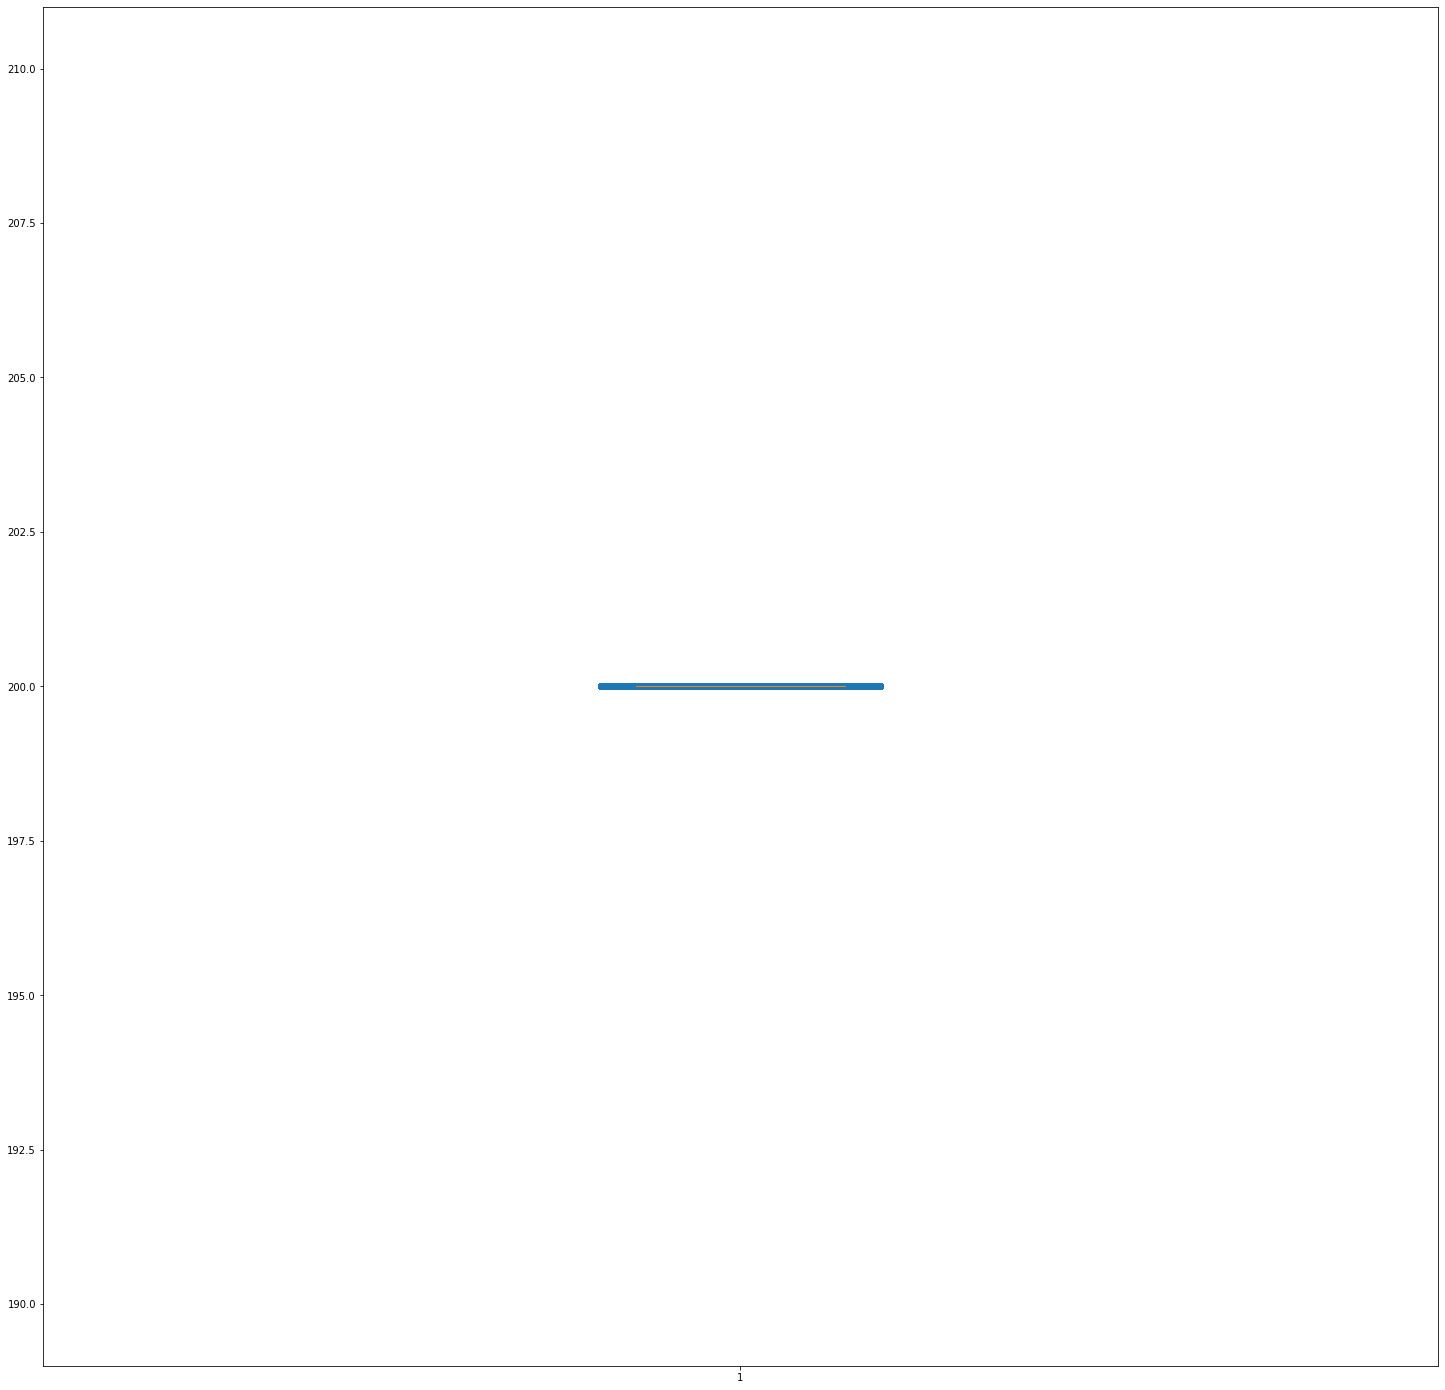

In [65]:
file = open("teacher_school_possiblities.json")
teacher_possibilites = json.load(file)
plt.boxplot(teacher_possibilites)
plt.scatter(0.9 + (numpy.random.random(len(teacher_possibilites)) / 5), teacher_possibilites)

In [66]:


with open("../recordings/v1.0.0-test.json") as file:
    output_area_polygons = json.load(file)
print(output_area_polygons.keys())

output_areas = set(output_area_polygons["OutputArea"].keys())
output_area_df = None
for area in output_area_polygons["OutputArea"]:
    records = []
    for record in output_area_polygons["OutputArea"][area]:
        record["code"] = area
        records.append(record)
    if output_area_df is None:
        output_area_df = pd.DataFrame(records)
    else:
        output_area_df = pd.concat([output_area_df, pd.DataFrame(records)])

#output_area_df.append()
#output_areas
output_area_df["code"].value_counts()




dict_keys(['OutputArea', 'All', 'PublicTransport'])


E00067302    861
E00067747    861
E00067431    861
E00067687    861
E00067300    861
            ... 
E00067550    666
E00067344    666
E00067692    666
E00067407    666
E00170149    666
Name: code, Length: 637, dtype: int64

In [67]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import shapefile as shp  # Requires the pyshp package
import matplotlib.pyplot as plt
from matplotlib import cm

colours = ["red", "blue"]
box_size = 200

sf = shp.Reader("../data/census_map_areas/England_oa_2011/england_oa_2011.shp")

output_area_polygons = {}
for shape in sf.shapeRecords():
    code = shape.record.as_dict(date_strings=True)["code"]
    if code in output_areas:
        points = shape.shape.points[:]
        output_area_polygons[code] = points  #



In [68]:
fig, axes = plt.subplots()
fig.set_dpi(400)
patches = []
# Draw Background of Output Areas
for (code, poly) in output_area_polygons.items():
    patches.append(Polygon(poly, closed=True))
collection = PatchCollection(patches, edgecolors="black", facecolors="dodgerblue")

#fig,ax=plt.subplots()
axes.add_collection(collection)

for citizen_type, colour in zip(school_positions, colours):
    x = list(map(lambda x: (x[0]), citizen_type))
    y = list(map(lambda x: (x[1]), citizen_type))
    axes.scatter(x, y, color="orange", label=colour, s=100)
    axes.legend()
axes.set_title("Location of Schools")


Text(0.5, 1.0, 'Location of Schools')

In [69]:
# From: https://stackoverflow.com/a/18228967
from mpl_toolkits.mplot3d import art3d
import numpy as np


def rotation_matrix(d):
    """
    Calculates a rotation matrix given a vector d. The direction of d
    corresponds to the rotation axis. The length of d corresponds to
    the sin of the angle of rotation.

    Variant of: http://mail.scipy.org/pipermail/numpy-discussion/2009-March/040806.html
    """
    sin_angle = np.linalg.norm(d)

    if sin_angle == 0:
        return np.identity(3)

    d /= sin_angle

    eye = np.eye(3)
    ddt = np.outer(d, d)
    skew = np.array([[0, d[2], -d[1]],
                     [-d[2], 0, d[0]],
                     [d[1], -d[0], 0]], dtype=np.float64)

    M = ddt + np.sqrt(1 - sin_angle ** 2) * (eye - ddt) + sin_angle * skew
    return M


def pathpatch_2d_to_3d(pathpatch, z=0, normal='z'):
    """
    Transforms a 2D Patch to a 3D patch using the given normal vector.

    The patch is projected into they XY plane, rotated about the origin
    and finally translated by z.
    """
    if type(normal) is str:  #Translate strings to normal vectors
        index = "xyz".index(normal)
        normal = np.roll((1.0, 0, 0), index)

    normal /= np.linalg.norm(normal)  #Make sure the vector is normalised

    path = pathpatch.get_path()  #Get the path and the associated transform
    trans = pathpatch.get_patch_transform()

    path = trans.transform_path(path)  #Apply the transform

    pathpatch.__class__ = art3d.PathPatch3D  #Change the class
    pathpatch._code3d = path.codes  #Copy the codes
    pathpatch._facecolor3d = pathpatch.get_facecolor  #Get the face color
    verts = path.vertices  #Get the vertices in 2D

    d = np.cross(normal, (0, 0, 1))  #Obtain the rotation vector
    M = rotation_matrix(d)  #Get the rotation matrix

    pathpatch._segment3d = np.array([np.dot(M, (x, y, 0)) + (0, 0, z) for x, y in verts])


def pathpatch_translate(pathpatch, delta):
    """
    Translates the 3D pathpatch by the amount delta.
    """
    pathpatch._segment3d += delta


def flatten(t):
    return [item for sublist in t for item in sublist]


/tmp/ipykernel_513352/3891905876.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = a3.Axes3D(fig, computed_zorder=False)


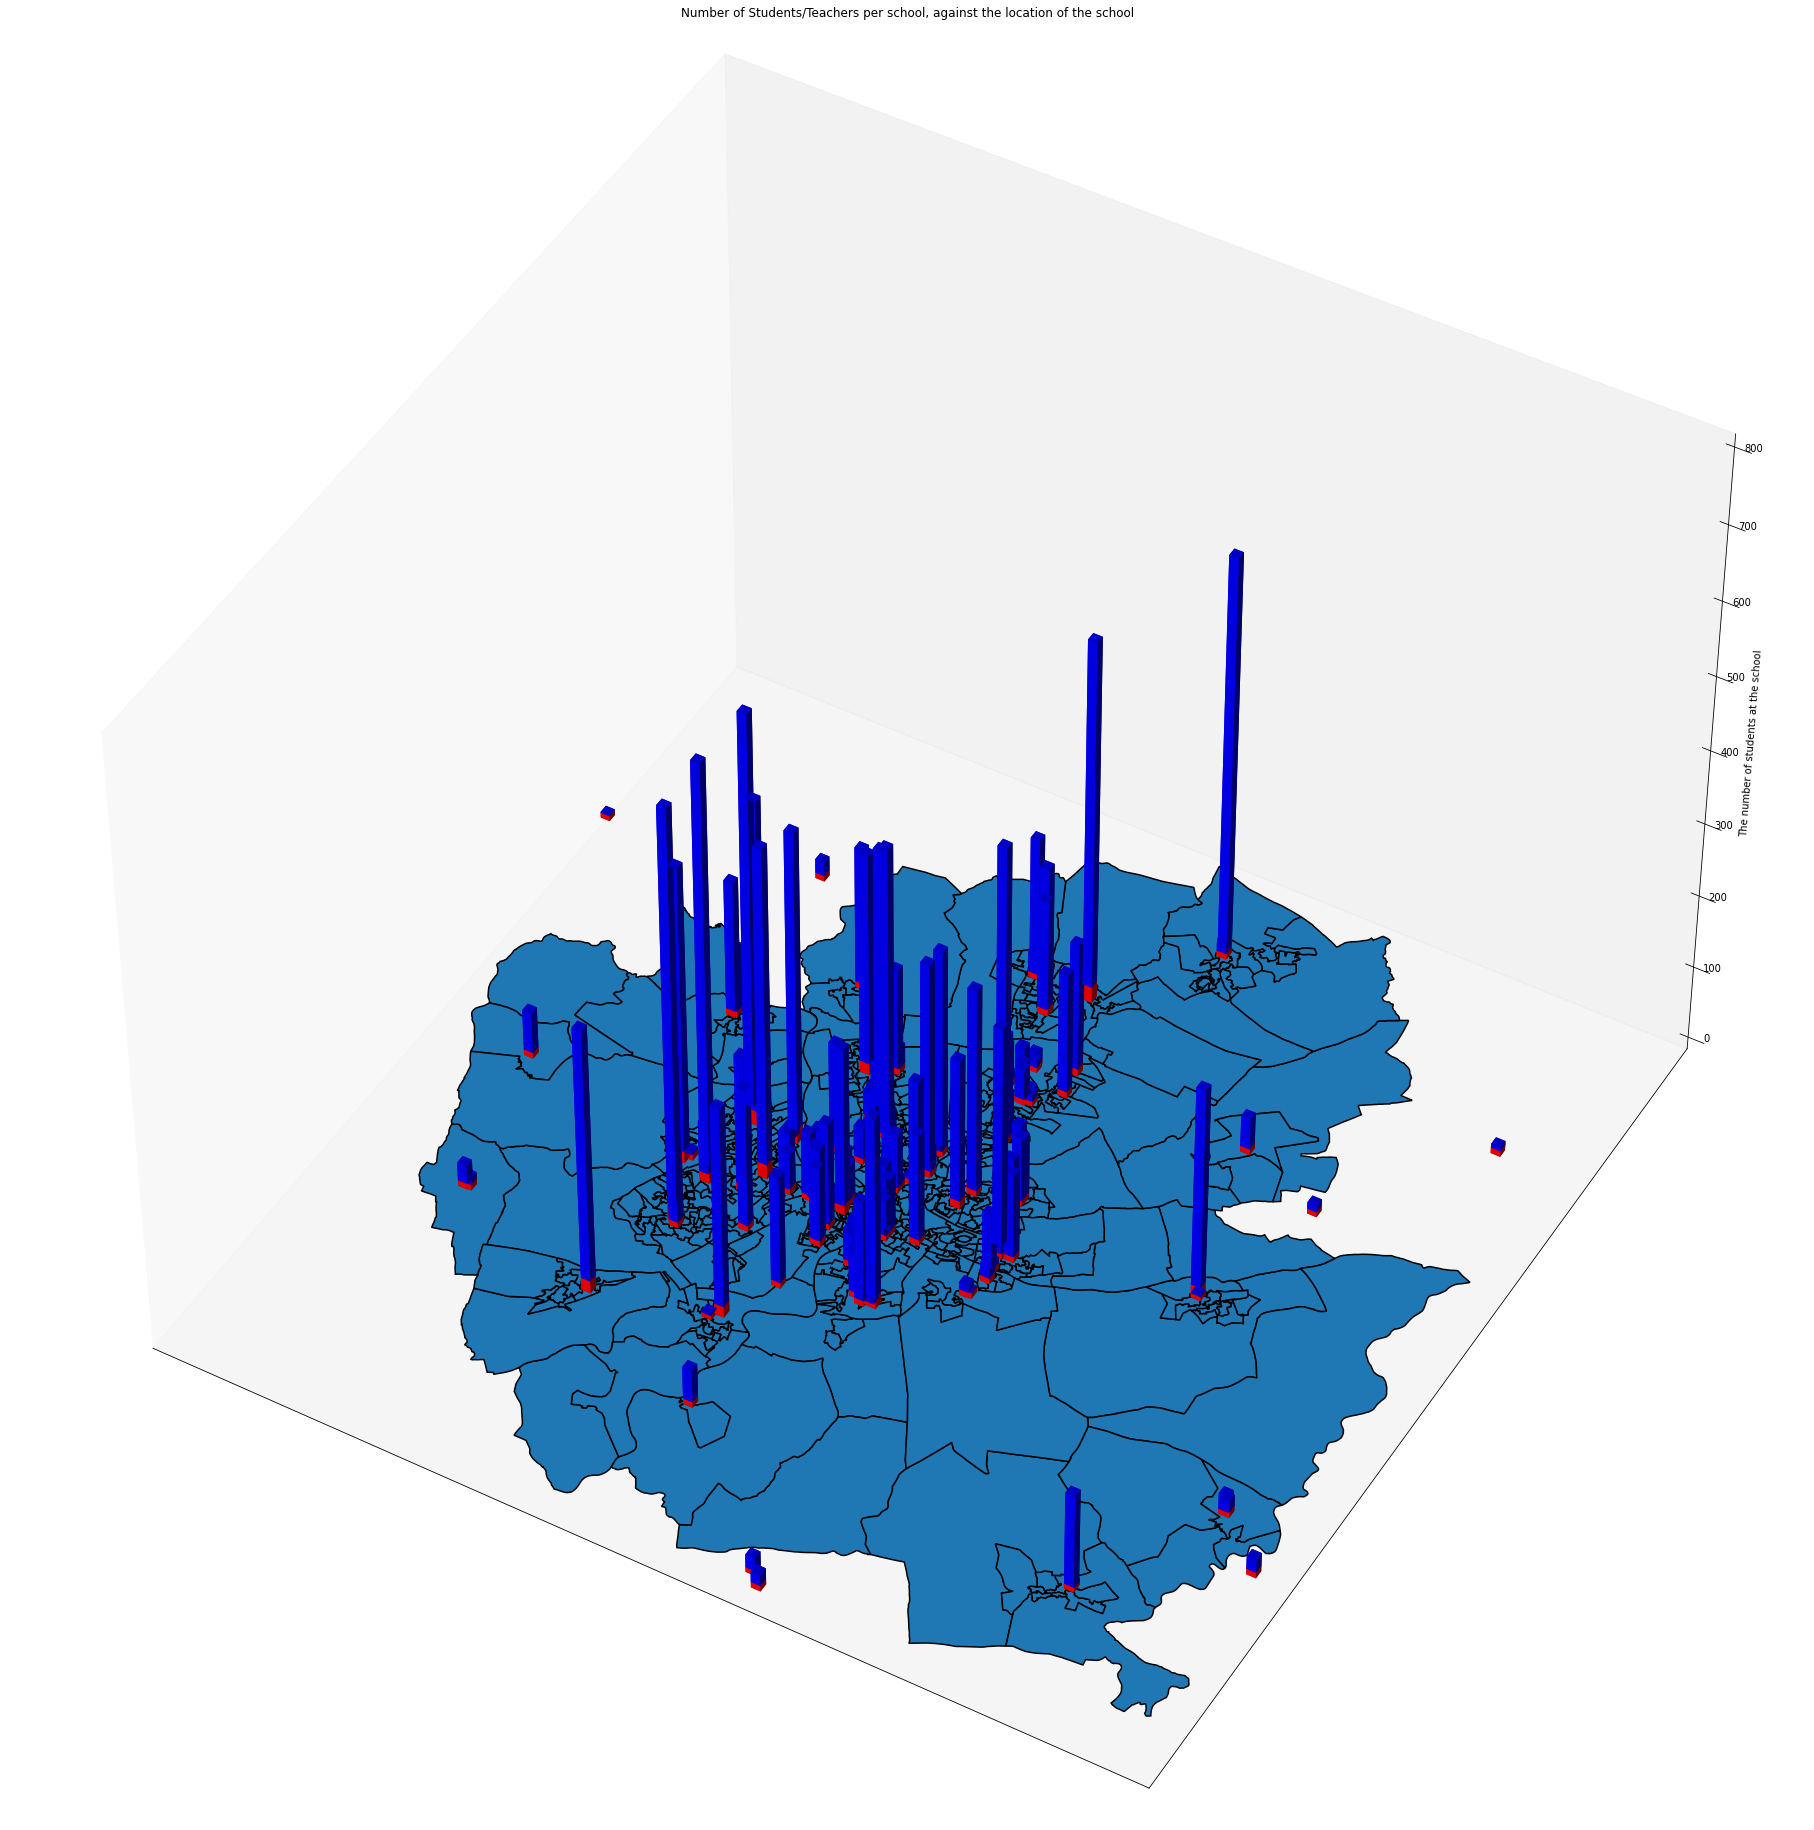

In [83]:
import mpl_toolkits.mplot3d as a3

fig = plt.figure()
axes = a3.Axes3D(fig, computed_zorder=False)
patches = []
# Draw Background of Output Areas
for (code, path) in output_area_polygons.items():
    #,edgecolor="black",facecolor="none"
    poly = Polygon(path, closed=True, zorder=2, alpha=1.0, linewidth=1.5, edgecolor="black")
    axes.add_patch(poly)
    pathpatch_2d_to_3d(poly, z=0, normal="z")
axes.autoscale()
x_min = min(map(lambda x: (x[0]), flatten(output_area_polygons.values())))
axes.set(xlim=(min(map(lambda x: (x[0]), flatten(output_area_polygons.values()))),
               max(map(lambda x: (x[0]), flatten(output_area_polygons.values())))), ylim=(
min(map(lambda x: (x[1]), flatten(output_area_polygons.values()))),
max(map(lambda x: (x[1]), flatten(output_area_polygons.values())))), zlim=(0, 800))

# Generate bar charts
z_heights = {}
for index, points in enumerate(school_positions):
    z_bottom = []
    for point in points:
        x, y, z = point
        if index == 0:
            z = z * 1

        if (x, y) in z_heights:
            offset = z_heights[(x, y)]
            z_bottom.append(offset)
            z_heights[(x, y)] += z
        else:
            z_bottom.append(0)
            z_heights[(x, y)] = z
    x, y, z = zip(*points)
    axes.bar3d(x, y, z_bottom, box_size, box_size, z, shade=True, label=name, color=colours[index], zorder=3)
axes.set_title("Number of Students/Teachers per school, against the location of the school")
axes.set_zlabel("The number of students at the school")
axes.grid(visible=False)
axes.set_xticks([])
axes.set_yticks([])
axes.view_init(45, )

Text(0, 0.5, 'Amount of classes that size')

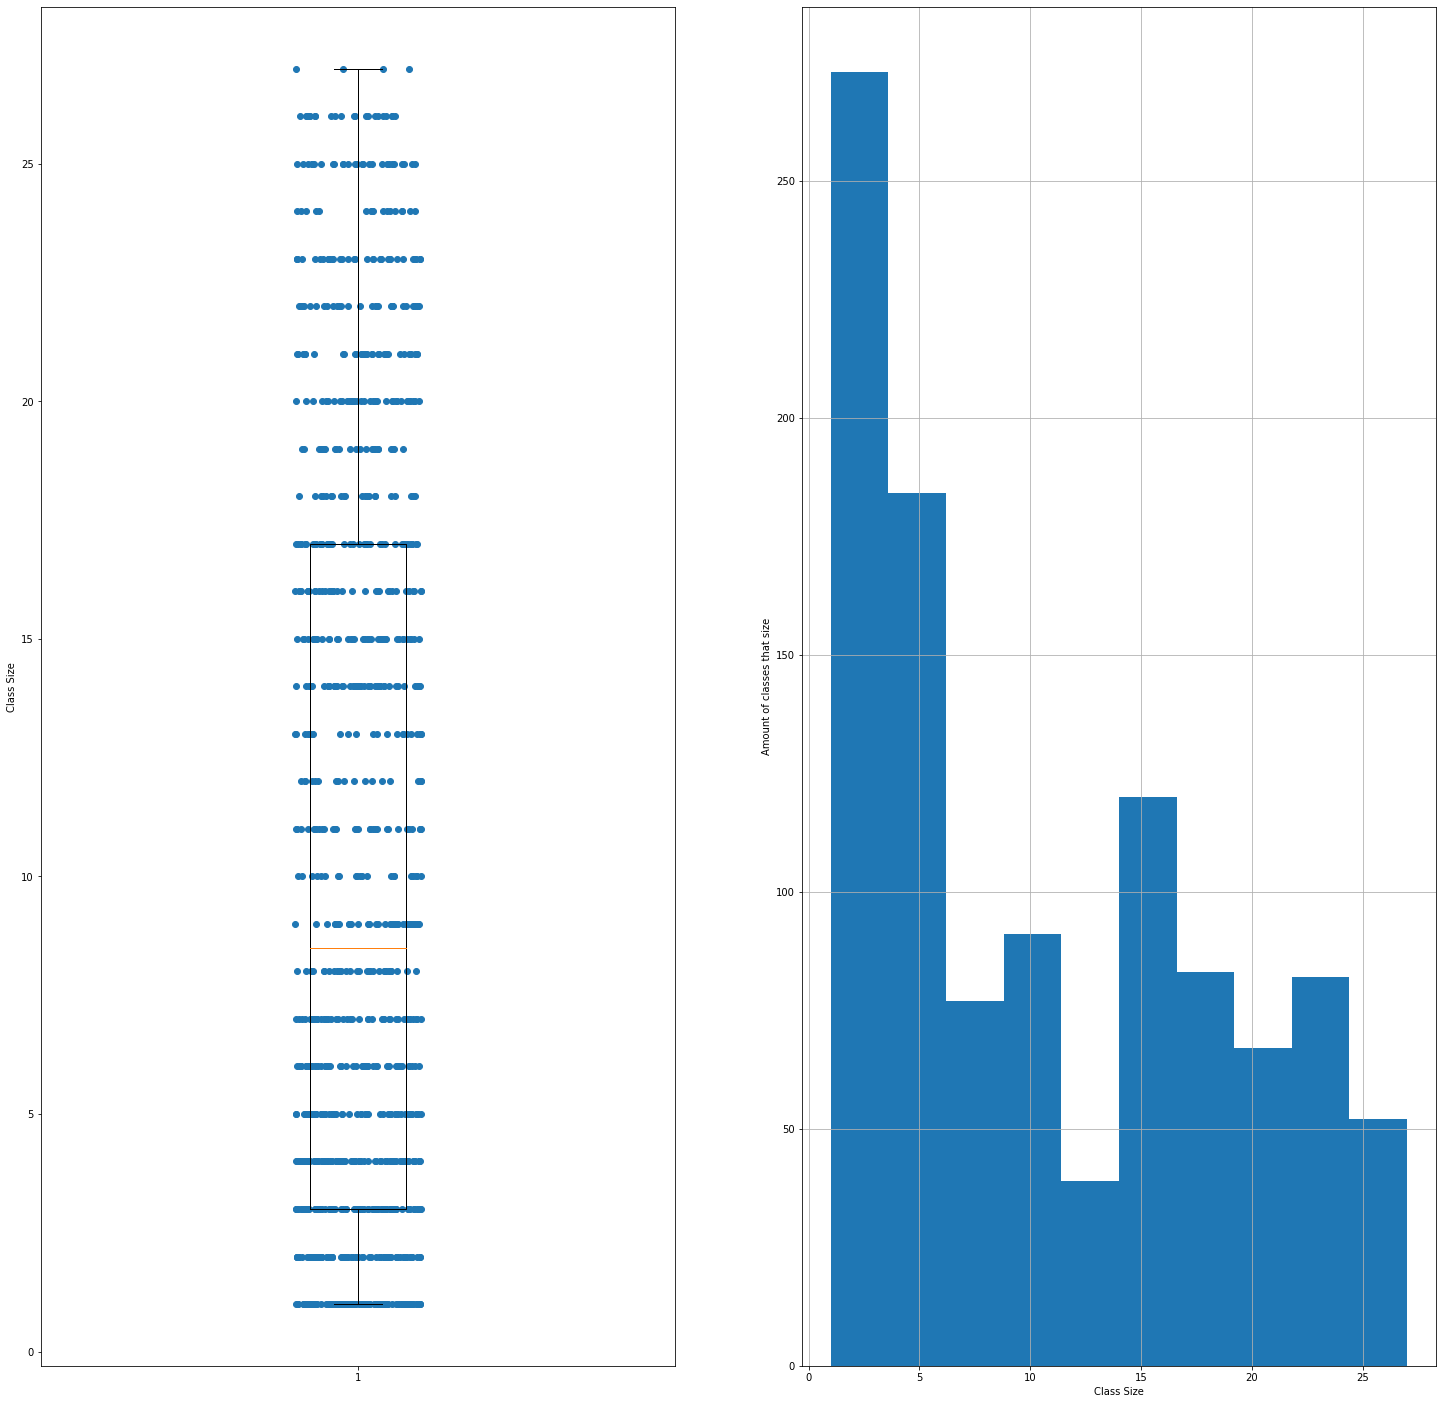

In [71]:
school_file = open("../debug_dumps/school_statistics.json")
school_data: dict[any] = json.load(school_file)
ages = {}
class_sizes = []
grouped_class_sizes={}
for school in school_data.values():
    for entry in school["students_per_age_group"]:
        (age, amount)=entry
        if age not in ages:
            ages[age] = []
        ages[age].append(amount)

    for class_size in school["class_sizes"]:
        class_sizes.append(class_size)
        if class_size not in grouped_class_sizes:
            grouped_class_sizes[class_size]=0
        grouped_class_sizes[class_size]+=1
fig,axes=plt.subplots(1,2)
axes[0].boxplot(class_sizes)
#fig.title("Class Sizes")
axes[0].scatter(0.9 + (numpy.random.random(len(class_sizes)) / 5), class_sizes)
axes[0].set_ylabel("Class Size")
axes[1].hist(class_sizes)#grouped_class_sizes.keys(),grouped_class_sizes.values())
axes[1].grid(True)
axes[1].set_xlabel("Class Size")
axes[1].set_ylabel("Amount of classes that size")